* This notebook experiments with new NestedAE architectures.
* Features that are useful are then pushed to the source code.

In [1]:
import math
import random
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import kstest, ks_2samp
import torch
from torch.nn import Module, ModuleList, ModuleDict, Linear, L1Loss
from torch.utils.data import DataLoader
from torch.optim import SGD
import pandas as pd
import seaborn as sns

import umap

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf, optimize_acqf_discrete

from shap.explainers import Exact
import shap

from NestedAE.nn_utils import check_dict_key_exists, set_layer_init

/Users/nikhilthota/miniconda3/envs/NestedAE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import all these packages when using SMAC

- Change conda env to SMAC to run the SMAC bayesian optimization system

In [ ]:
import numpy as np
import pandas as pd
import torch
from smac import Scenario, BlackBoxFacade, HyperparameterOptimizationFacade

#### Define the model

In [2]:
ae_module = 'ae1'
class AE(Module):
    def __init__(self, module_params):
        super(AE, self).__init__()
        ae_modules = {}
        # Outer loop iterates over the ae_modules
        for module_name, module_dict in module_params['modules'].items():
            layer_list = ModuleList()
            # Check for existence of keys or take defualts if not present
            if check_dict_key_exists('hidden_layers', module_dict):
                hidden_layers = module_dict['hidden_layers']
            else:
                hidden_layers = 0
            if check_dict_key_exists('hidden_dim', module_dict):
                hidden_dim = module_dict['hidden_dim']
            else:
                hidden_dim = None
            if check_dict_key_exists('hidden_activation', module_dict):
                hidden_activation = module_dict['hidden_activation']
            else:
                hidden_activation = None
            if check_dict_key_exists('output_activation', module_dict):
                output_activation = module_dict['output_activation']
            else:
                output_activation = None
            if check_dict_key_exists('layer_dropout', module_dict):
                layer_dropout = module_dict['layer_dropout']
            else:
                layer_dropout = None
            if check_dict_key_exists('layer_kernel_init', module_dict):
                layer_kernel_init = module_dict['layer_kernel_init']
            else:
                layer_kernel_init = None
            if check_dict_key_exists('layer_bias_init', module_dict):
                layer_bias_init = module_dict['layer_bias_init']
            else:
                layer_bias_init = None
            if check_dict_key_exists('load_params', module_dict):
                load_params = module_dict['load_params']
            else:
                load_params = False

            num_layers = hidden_layers + 1
            for layer_num in range(num_layers):
                if layer_num == 0:
                    # Calculate the input dimensions to first layer
                    input_dim = module_dict['input_dim']

                    if hidden_dim is not None:
                        layer_list.append(Linear(in_features=input_dim,
                                                out_features=module_dict['hidden_dim'],
                                                bias=True))
                    else:
                        layer_list.append(Linear(in_features=input_dim,
                                                out_features=module_dict['output_dim'],
                                                bias=True))
                        if output_activation:
                            layer_list.append(output_activation)
                        break # Only output layer
                elif layer_num == num_layers - 1:
                    layer_list.append(Linear(in_features=module_dict['hidden_dim'],
                                                out_features=module_dict['output_dim'],
                                                bias=True))
                    if output_activation:
                        layer_list.append(output_activation)
                    break # Dont add hidden activations
                else:
                    layer_list.append(Linear(in_features=module_dict['hidden_dim'],
                                                out_features=module_dict['hidden_dim'],
                                                bias=True))
                # Add hidden activations if specified
                if hidden_activation:
                    layer_list.append(hidden_activation)
                if layer_dropout:
                    layer_list.append(layer_dropout)
            # Initialize weights for all layers
            if layer_kernel_init:
                layer_list = set_layer_init(layer_list, module_dict, init='kernel')
            if layer_bias_init:
                layer_list = set_layer_init(layer_list, module_dict, init='bias')

            # Finally add to ae_module list
            ae_modules[module_name] = layer_list
        self.ae_modules = ModuleDict(ae_modules)

    def forward(self, x):
        """Forward pass through the model."""
        # Stores all module outputs
        ae_module_outputs = {}

        # Pass through encoder
        for j, layer in enumerate(self.ae_modules['encoder']):
            if j == 0:
                ae_module_outputs['z'] = layer(x)
            else:
                ae_module_outputs['z'] = layer(ae_module_outputs['z'])

        # # Pass through predictor
        # for j, layer in enumerate(self.ae_modules['bandgaps_predictor']):
        #     if j == 0:
        #         ae_module_outputs['y1_pred'] = layer(ae_module_outputs['z'])
        #     else:
        #         ae_module_outputs['y1_pred'] = layer(ae_module_outputs['y1_pred'])

        # Pass through predictor
        for j, layer in enumerate(self.ae_modules['BE_predictor']):
            if j == 0:
                ae_module_outputs['y1_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['y1_pred'] = layer(ae_module_outputs['y1_pred'])

        for j, layer in enumerate(self.ae_modules['latents_predictor']):
            if j == 0:
                ae_module_outputs['latents_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['latents_pred'] = layer(ae_module_outputs['latents_pred'])

        # for j, layer in enumerate(self.ae_modules['A_predictor']):
        #     if j == 0:
        #         ae_module_outputs['design1_pred'] = layer(ae_module_outputs['z'])
        #     else:
        #         ae_module_outputs['design1_pred'] = layer(ae_module_outputs['design1_pred'])

        # for j, layer in enumerate(self.ae_modules['B_predictor']):
        #     if j == 0:
        #         ae_module_outputs['design2_pred'] = layer(ae_module_outputs['z'])
        #     else:
        #         ae_module_outputs['design2_pred'] = layer(ae_module_outputs['design2_pred'])

        # for j, layer in enumerate(self.ae_modules['X_predictor']):
        #     if j == 0:
        #         ae_module_outputs['design3_pred'] = layer(ae_module_outputs['z'])
        #     else:
        #         ae_module_outputs['design3_pred'] = layer(ae_module_outputs['design3_pred'])

        for j, layer in enumerate(self.ae_modules['decoder']):
            if j == 0:
                ae_module_outputs['x_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['x_pred'] = layer(ae_module_outputs['x_pred'])

        for j, layer in enumerate(self.ae_modules['solvent_predictor']):
            if j == 0:
                ae_module_outputs['design1_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['design1_pred'] = layer(ae_module_outputs['design1_pred'])

        return ae_module_outputs

#### Datasets Details

In [ ]:
# ---------------------------------------------------------
# For bandgaps and binding  energy combined dataset
# dataset_loc = 'datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_dataset/perov_bandgaps_PBE_arun_reduced.csv'
# For this dataset : 
dataset_loc = 'datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_dataset/perov_solv_BE_for_nestedae.csv'
# sheet_name = ''

#########################################
# FOR ABX3 BANDGAP DATASET 
#########################################

# latent_col_names = []
latent_col_names = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10']

# Descriptors when just using the binding energy dataset
# descriptors = ['A_IONRAD',
#                 'A_MASS',
#                 'A_DPM',
#                 # 'B_IONRAD',
#                 # 'B_MASS',
#                 # 'B_EA',
#                 # 'B_IE',
#                 # 'B_En',
#                 # 'B_AN',
#                 'X_IONRAD',
#                 'X_MASS',
#                 'X_EA',
#                 'X_IE',
#                 'X_En',
#                 'X_AN',
#                 'SOLV_DENSITY',
#                 'SOLV_DIELECTRIC',
#                 'SOLV_GDN',
#                 'SOLV_DPM',
#                 'SOLV_MV',
#                 'SOLV_UMBO'
#             ]

# descriptors = ['A_IONRAD',
#                'A_MASS',
#                'A_DPM',
#                'B_IONRAD',
#                'B_MASS',
#                'B_EA',
#                'B_IE',
#                'B_En',
#                'B_AN',
#                'X_IONRAD',
#                'X_MASS',
#                'X_EA',
#                'X_IE',
#                'X_En',
#                'X_AN'
# ]
descriptors = ['SOLV_DENSITY',
               'SOLV_DIELECTRIC',
               'SOLV_GDN',
               'SOLV_DPM',
               'SOLV_MV',
               'SOLV_UMBO']

# target = ['Gap']
target = ['Target']

# target_A_ion = ['K', 'Rb', 'Cs', 'MA', 'FA']
# target_B_ion = ['Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb']
# target_X_ion = ['Cl', 'Br', 'I']
target_solvent = ['DMSO', 'THTO', 'DMF', 'NMP', 'ACETONE', 'METHA', 'GBL', 'NITRO']

standardize_descs = True

split_strategy = 'strat_kfold'
train_split = 0.9
# For dataset 1
# defined_qs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# For dataset 2
defined_qs = [0.2, 0.4, 0.6, 0.8]

random_state = 42

plot_train_test_dist = False

plot_pcc_matrix = False

model_save_dir = 'ae2_bandgaps_THEN_perov_solv_BE'
# ---------------------------------------------------------

X_dataframe = pd.read_csv(dataset_loc)[descriptors + latent_col_names]
# Y_dataframe = pd.read_csv(dataset_loc)[target + target_A_ion + target_B_ion + target_X_ion]
Y_dataframe = pd.read_csv(dataset_loc)[target + target_solvent]

if standardize_descs:
    desc_means = []
    desc_std_devs = []
    for desc in X_dataframe.columns.tolist():
        mean = X_dataframe[desc].mean()
        desc_means.append(mean)
        std_dev = X_dataframe[desc].std()
        desc_std_devs.append(std_dev)
        X_dataframe[desc] = (X_dataframe[desc] - mean) / std_dev
    print('Descriptors standardized.')
else:
    print('Descriptors not standardized.')

print(f'Dataframe Statistics : {X_dataframe.describe()}')

print(f'Dataset columns : \n')
print(X_dataframe.columns)
# dataset = np.concatenate((X_dataframe.to_numpy(dtype=np.float32), 
#                           Y_dataframe[target].to_numpy(dtype=np.float32),
#                           Y_dataframe[target_A_ion].to_numpy(dtype=np.float32),
#                           Y_dataframe[target_B_ion].to_numpy(dtype=np.float32),
#                           Y_dataframe[target_X_ion].to_numpy(dtype=np.float32)),
#                           axis=1)
dataset = np.concatenate((X_dataframe.to_numpy(dtype=np.float32), 
                          Y_dataframe[target].to_numpy(dtype=np.float32),
                          Y_dataframe[target_solvent].to_numpy(dtype=np.float32)), axis=1)
print(dataset.shape)

Descriptors standardized.
Dataframe Statistics :        SOLV_DENSITY  SOLV_DIELECTRIC      SOLV_GDN      SOLV_DPM     SOLV_MV  \
count    240.000000     2.400000e+02  2.400000e+02  2.400000e+02  240.000000   
mean       0.000000     5.329071e-16 -5.921189e-17 -1.125026e-15    0.000000   
std        1.000000     1.000000e+00  1.000000e+00  1.000000e+00    1.000000   
min       -1.714765    -1.999426e+00 -1.639427e+00 -1.711390e+00   -1.993231   
25%       -0.639561    -3.470079e-01 -4.997303e-01 -5.486064e-01   -0.377720   
50%        0.176111     2.692996e-01  2.749073e-01  4.218368e-01   -0.047084   
75%        0.732251     6.792780e-01  7.579428e-01  7.715461e-01    0.557686   
max        1.399619     1.198227e+00  1.120776e+00  9.988571e-01    1.564242   

          SOLV_UMBO            l0            l1            l2            l3  \
count  2.400000e+02  2.400000e+02  2.400000e+02  2.400000e+02  2.400000e+02   
mean   5.921189e-17  1.535809e-16  2.775558e-17 -6.476301e-17 -7.771561e

### Compare with other models

In [ ]:
x = X_dataframe.to_numpy(dtype=np.float32)
y = Y_dataframe[target].to_numpy(dtype=np.float32)

print(f'The quantiles : {np.quantile(y, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}')
y_binned = np.digitize(y, np.quantile(y, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
# kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
split_idxs_all_folds = []
for fold, (train_idx, val_idx) in enumerate(skf.split(x, y_binned)):
# for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
    split_idxs_all_folds.append((train_idx, val_idx))
    ks_stat, p_value = ks_2samp(y[train_idx], y[val_idx])
    print(f'Fold {fold} : KS statistic = {ks_stat}, p-value = {p_value}')

from xgboost import XGBRegressor

param_grid_xgb = {
        'n_estimators': [250, 500, 1000, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4, 5],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        # 'colsample_bytree': [0.6, 0.8, 1.0],
        # 'alpha': [0, 0.01, 0.1],
        # 'lambda':[0, 0.01, 0.1]
    }
param_grid_RF = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [2, 3, 4, 5, 10],
    'ccp_alpha': [0.0, 0.01, 0.1]
}
param_grid_nusvr = {
    'nu': [0.25, 0.5, 0.75],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],  # Only relevant for 'poly' kernel
    'coef0': [0.0, 0.1, 0.5],  # Only relevant for 'poly' and 'sigmoid' kernels
    'C': [0.5, 1, 5, 10, 50, 100]
}
param_grid_lasso = {
        'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]
}
param_grid_ridge = {
          'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]
}

grid = GridSearchCV(estimator=XGBRegressor(random_state=random_state),
                    param_grid=param_grid_xgb,
                    scoring='neg_mean_absolute_error', 
                    cv=split_idxs_all_folds, # If using None defaults to 5 fold cross-validation
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True)
grid.fit(x, y.squeeze())
print(f'Best parameters found: {grid.best_params_}') # Parameter setting that gave best performance on hold out data
print(f'Best Cross validated score of the best estimator found: {-grid.best_score_}') # Mean cross-validated score of the best_estimator
# Get the mean absolute error on the training set across all folds for best model
print(f"Mean test score of the best estimator across all folds : {grid.cv_results_['mean_test_score'][grid.best_index_]}")
print(f"Std of test score of the best estimator across all folds : {grid.cv_results_['std_test_score'][grid.best_index_]}")
print(f"Mean train score of the best estimator across all folds : {grid.cv_results_['mean_train_score'][grid.best_index_]}")
print(f"Std of train score of the best estimator across all folds : {grid.cv_results_['std_train_score'][grid.best_index_]}")

# Find the indices of top 10 test scores
top_10_indices = sorted(range(len(grid.cv_results_['mean_test_score'])), key=lambda i: grid.cv_results_['mean_test_score'][i], reverse=True)[:10]
# Get the top 10 parameter sets
print("Top 10 parameter sets:")
for idx in top_10_indices:
    print(f"Params: {grid.cv_results_['params'][idx]}, Mean Test Score: {grid.cv_results_['mean_test_score'][idx]}, Std Test Score: {grid.cv_results_['std_test_score'][idx]}")

In [ ]:
# https://github.com/Ekeany/Boruta-Shap -> Change to boruta_shap conda env

# use boruta_shap env and import these libraries in the top cell 
# from BorutaShap import BorutaShap
# import pandas as pd
# import numpy as np

feature_selector = BorutaShap(importance_measure='shap', classification=False)
feature_selector.fit(X=pd.DataFrame(dataset[:, :(len(latent_col_names + descriptors))], columns=latent_col_names + descriptors),
                     y=dataset[:, 15].reshape(-1, 1), 
                     n_trials=100,
                     sample=False,
                     train_or_test='train',
                     random_state=random_state,
                     normalize=True,
                     verbose=True) # importance values normaized accdg to Z score
feature_selector.plot(which_features='all', y_scale=None) # Convert to log by y_scale='log'

In [ ]:
data = feature_selector.history_x.iloc[1:]
data['index'] = data.index
data = pd.melt(data, id_vars='index', var_name='Methods')

decision_mapper = feature_selector.create_mapping_of_features_to_attribute(maps=['Tentative','Rejected','Accepted', 'Shadow'])
data['Decision'] = data['Methods'].map(decision_mapper)
data.drop(['index'], axis=1, inplace=True)

options = { 'accepted' : feature_selector.filter_data(data,'Decision', 'Accepted'),
            'tentative': feature_selector.filter_data(data,'Decision', 'Tentative'),
            'rejected' : feature_selector.filter_data(data,'Decision', 'Rejected'),
            'all' : data}
print(data)

# Save data to csv file
data.to_csv('data.csv', index=False)


#### Data Distribution Analysis

In [4]:
train_idxs = []
val_idxs = []
if split_strategy == 'kfold':
    kf = KFold(n_splits=int(1/(1 - train_split)), shuffle=True, random_state=random_state)
    for (train_idx, val_idx) in kf.split(dataset):
        train_idxs.append(train_idx)
        val_idxs.append(val_idx)
elif split_strategy == 'strat_kfold':
    print('Using a stratified k fold split strategy.')
    y = Y_dataframe[target].to_numpy(dtype=np.float32)
    skf = StratifiedKFold(n_splits=int(1/(1 - train_split)), shuffle=True, random_state=random_state)
    y_binned = np.digitize(y, np.quantile(y, defined_qs))
    for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, y_binned)):
        train_idxs.append(train_idx)
        val_idxs.append(val_idx)
        ks_stat, p_val = ks_2samp(y[train_idx], y[val_idx])
        print(f'Fold {fold} ks-stat for target: {np.round(ks_stat, 3)}, p-value: {np.round(p_val, 3)}')
elif split_strategy == 'random':    
    # Train - Test split of indices
    idxs = list(range(X_dataframe.shape[0]))
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        random.shuffle(idxs)
        train_idxs.append(idxs[:int(train_split*len(idxs))])
        val_idxs.append(idxs[int(train_split*len(idxs)):])
else:
    raise ValueError(f'Unknown split strategy: {split_strategy}')

# for_fold = 5
# # Check how do the histograms of train and test distribution match up
# if plot_train_test_dist:
#     X_dataframe_train = X_dataframe.iloc[train_idxs[for_fold]]
#     Y_dataframe_train = Y_dataframe.iloc[train_idxs[for_fold]]
#     X_dataframe_test = X_dataframe.iloc[val_idxs[for_fold]]
#     Y_dataframe_test = Y_dataframe.iloc[val_idxs[for_fold]]
#     # for col in X_dataframe.columns:
#     #     # ks_1samp takes distribution of sample we want to compare (F(x)) against a continuous dist. (G(x))
#     #     ks_stat, p_value = ks_2samp(X_dataframe_train[col], X_dataframe_test[col])
#     #     plt.figure(figsize=(5, 3))
#     #     sns.histplot(X_dataframe_train[col], kde=True, label='Train', color='blue', stat='probability', binwidth=0.1)
#     #     sns.histplot(X_dataframe_test[col], kde=True, label='Test', color='red', stat='probability', binwidth=0.1)
#     #     plt.title(f'Distribution of {col}')
#     #     plt.xlabel(col)
#     #     plt.ylabel('Density')
#     #     plt.figtext(0.15, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', bbox=dict(facecolor='white', alpha=0.5))
#     #     plt.legend()
#     #     plt.show()

#     # Combine all histograms into a single plot
#     fig, ax = plt.subplots(3, 5, figsize=(20, 10))
#     ax = ax.flatten()
#     for col in X_dataframe.columns:
#         ks_stat, p_value = ks_2samp(X_dataframe_train[col], X_dataframe_test[col])
#         # plt.figure(figsize=(5, 3))
#         ax = fig.add_subplot(3, 5, X_dataframe.columns.get_loc(col)+1)
#         ax.set_title(f'Distribution of {col}')
#         ax.set_xlabel(col)
#         ax.set_ylabel('Density')
#         # ax.set_figtext(0.15, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', bbox=dict(facecolor='white', alpha=0.5))
#         sns.histplot(X_dataframe_train[col], kde=False, label='Train', color='blue', stat='probability', binwidth=0.1)
#         sns.histplot(X_dataframe_test[col], kde=False, label='Test', color='red', stat='probability', binwidth=0.1)
#         ax.text(0.5, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', transform=ax.transAxes,
#                 bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
#         # Remove axis label
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.legend()
#     plt.tight_layout()
#     plt.show()


Using a stratified k fold split strategy.
Fold 0 ks-stat for target: [0.083], p-value: [0.996]
Fold 1 ks-stat for target: [0.13], p-value: [0.827]
Fold 2 ks-stat for target: [0.079], p-value: [0.998]
Fold 3 ks-stat for target: [0.111], p-value: [0.933]
Fold 4 ks-stat for target: [0.102], p-value: [0.966]
Fold 5 ks-stat for target: [0.093], p-value: [0.986]
Fold 6 ks-stat for target: [0.102], p-value: [0.966]
Fold 7 ks-stat for target: [0.088], p-value: [0.992]
Fold 8 ks-stat for target: [0.111], p-value: [0.933]
Fold 9 ks-stat for target: [0.144], p-value: [0.725]


### Pearson Correlation Analysis

In [ ]:
# Computing the pearson correlation coefficients (ALWAYS USE THE TRAINING DATASET TO AVOID DATA LEAKAGE)
# choose_descriptors = latent_col_names + descriptors + target + target_A_ion + target_B_ion + target_X_ion
choose_descriptors = latent_col_names + descriptors + target_solvent
choose_train_idx = 0
if plot_pcc_matrix:
    pcc = np.round(np.corrcoef(x=dataset[train_idxs[choose_train_idx]][:,:len(choose_descriptors)], rowvar=False), 2)
    # Ref : Gryffin, https://online.ucpress.edu/collabra/article/9/1/87615/197169/A-Brief-Note-on-the-Standard-Error-of-the-Pearson
    std_err_pcc = 1/((dataset[train_idxs[0]].shape[0] - 3)**0.5)
    print(f'Standard error in PCC : {std_err_pcc}')
    adj_pcc = (np.abs(pcc) - std_err_pcc)/(1 - std_err_pcc)
    adj_pcc[adj_pcc < 0] = 0  # Ensure no negative values in adjusted PCC

    # Add correlatin coeff values to the plot
    fig, ax = plt.subplots(figsize=(16, 16))
    pcc_plot = ax.matshow(adj_pcc, cmap='coolwarm', vmin=-1, vmax=1)
    for i in range(adj_pcc.shape[0]):
        for j in range(adj_pcc.shape[1]):
            plt.text(j, i, f'{adj_pcc[i, j]:.2f}', ha='center', va='center', color='black')
    ax.set_yticks(ticks=np.arange(len(choose_descriptors)), labels=choose_descriptors, rotation=0)
    ax.set_xticks(ticks=np.arange(len(choose_descriptors)), labels=choose_descriptors, rotation=90)
    ax.set_yticks(ticks=np.arange(len(choose_descriptors)))
    ax.set_xticks(ticks=np.arange(len(choose_descriptors)))
    # Add the colorbar
    cbar = plt.colorbar(pcc_plot, ax=ax, fraction=0.0455)
    # cbar.set_label('Adjusted Pearson Correlation Coefficient', rotation=270, labelpad=20)
    # plt.title('Adjusted Pearson Correlation Coefficient Matrix')
    plt.tight_layout()
    plt.show()

#### Train the model

In [6]:
##########################
# Training params
num_epochs = 1000
lr = 0.01
# Optimization loss params
l2_coeff = 0
l1_coeff = 0.001
prop_l1_coeff = 0.001
# Model params
num_y1_latents = 1
# Printing params
print_every_n_batches = 100
print_losses = False
debug = False
pred_lam = 1
design_lam = 1
latent_lam = 10
##########################

class Arctanh(torch.nn.Module):
    def forward(self, x):
        return torch.atanh(torch.clamp(x, -0.999999, 0.999999))
    
atanh_act_fn = Arctanh()

# For AE1 trained on bandgaps dataset
# latent_dim = 11
# For HD1 trained on bandgaps dataset
# latent_dim = 10

# For AE2 trained on mhp-solvent-be dataset
latent_dim = 7
# For HD2 trained on mhp-solvent-be dataset
# latent_dim = 6

module_params = {'name':'AE1', 
                    'modules':{

                        'encoder':{
                            'input_dim':17,
                            'output_dim':latent_dim, 
                            'hidden_dim':25, 
                            'hidden_layers':1, 
                            'hidden_activation':None, 
                            'output_activation':torch.nn.Tanh(), 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },

                        # 'bandgaps_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':1,
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':torch.nn.ReLU(),
                        #     'output_activation':torch.nn.ReLU(),
                        #     # 'layer_dropout':torch.nn.Dropout(p=0.5),
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'},

                        'BE_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':1,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':torch.nn.ReLU(),
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                        'latents_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':11,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':None,
                            'output_activation':torch.nn.Tanh(),
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        # 'A_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':5,
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':torch.nn.ReLU(),
                        #     'output_activation':None,
                        #     # 'layer_dropout':torch.nn.Dropout(p=0.5),
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'
                        # },

                        # 'B_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':6,
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':torch.nn.ReLU(),
                        #     'output_activation':None,
                        #     # 'layer_dropout':torch.nn.Dropout(p=0.5),
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'
                        # },

                        # 'X_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':3,
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':torch.nn.ReLU(),
                        #     'output_activation':None,
                        #     # 'layer_dropout':torch.nn.Dropout(p=0.5),
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'
                        # },

                        'decoder':{
                            'input_dim':latent_dim,
                            'output_dim':6,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                        'solvent_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':8,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                    }}

train_total_pred_loss_per_epoch_per_seed = []
train_y_pred_loss_per_epoch_per_seed = []
train_design_pred_loss_per_epoch_per_seed = []
train_latent_pred_loss_per_epoch_per_seed = []
train_x_pred_loss_per_epoch_per_seed = []

val_y_pred_loss_per_epoch_per_seed = []
val_design_pred_loss_per_epoch_per_seed = []
val_latent_pred_loss_per_epoch_per_seed = []
val_x_pred_loss_per_epoch_per_seed = []

ind_losses_dict_train = {}
ind_losses_dict_val = {}

# for i, seed in enumerate(seeds):
for i in range(len(train_idxs)):
    print('\n')
    print(f'Fold {i}')
    print('\n' )
    train_dataset = dataset[train_idxs[i]]
    val_dataset = dataset[val_idxs[i]]

    print(f'Train numpy dataset shape : {train_dataset.shape}, Val. numpy dataset shape : {val_dataset.shape}')

    torch_train_dataset = torch.from_numpy(train_dataset).to(dtype=torch.float32)
    train_data_loader = DataLoader(torch_train_dataset, batch_size=train_dataset.shape[0], shuffle=True)

    torch_val_dataset = torch.from_numpy(val_dataset).to(dtype=torch.float32)
    val_data_loader = DataLoader(torch_val_dataset, batch_size=val_dataset.shape[0], shuffle=False)

    # RANDOM USED HERE - Param init
    # Delete previos model
    if i > 0:
        print("Deleting previous model")
        del ae
        ae = None
    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    ae = AE(module_params)
    print(ae)

    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    adam = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=l2_coeff)
    x_l1_loss = L1Loss(reduction='mean')

    y1_l1_loss = L1Loss(reduction='mean')

    design1_loss = torch.nn.CrossEntropyLoss(reduction='mean')
    design2_loss = torch.nn.CrossEntropyLoss(reduction='mean')
    design3_loss = torch.nn.CrossEntropyLoss(reduction='mean')

    latent_l1_loss = L1Loss(reduction='mean')

    train_total_pred_loss_per_epoch = []

    train_y_pred_loss_per_epoch = []
    train_design_pred_loss_per_epoch = []
    train_latent_pred_loss_per_epoch = []
    train_x_pred_loss_per_epoch = []

    val_y_pred_loss_per_epoch = []
    val_design_pred_loss_per_epoch = []
    val_latent_pred_loss_per_epoch = []
    val_x_pred_loss_per_epoch = []

    for epoch in range(num_epochs):
        train_total_pred_loss_per_batch = 0
        train_y_pred_loss_per_batch = 0
        train_design_pred_loss_per_batch = 0
        train_latent_pred_loss_per_batch = 0
        train_x_pred_loss_per_batch = 0

        # Train Loop
        print(f' --------- Epoch Stats {epoch+1}/{num_epochs} --------- ')
        for batch, data in enumerate(train_data_loader):
            ae.train()

            #
            # Select the X and y data
            #

            x = data[:, 0:(len(descriptors) + len(latent_col_names))]
            descrip_true = data[:, 0:len(descriptors)]
            
            if len(latent_col_names) > 0:
                latents = data[:, len(descriptors):(len(descriptors) + len(latent_col_names))]
            
            # Add additional property predictions here ..
            y1 = data[:, len(descriptors) + len(latent_col_names)]

            # For dataset 1
            # design1 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion))]
            # design2 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion))]
            # design3 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
            # # For dataset 2
            design1 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_solvent))]

            #
            # Extract the AE prediuctions
            #

            # sgd.zero_grad()
            adam.zero_grad()
            ae_out = ae(x)
            y1_pred, z = ae_out['y1_pred'], ae_out['z']
            x_pred = ae_out['x_pred']

            # For dataset 1
            # design1_pred, design2_pred, design3_pred = ae_out['design1_pred'], ae_out['design2_pred'], ae_out['design3_pred']
            # For dataset 2
            design1_pred = ae_out['design1_pred']

            if len(latent_col_names) > 0:
                latents_pred = ae_out['latents_pred']
            
            #
            #  Calculate the prediction losses
            #

            train_y1_pred_loss = y1_l1_loss(y1_pred, y1.reshape(-1, 1))
            if print_losses:print('train_y1_pred_loss:', train_y1_pred_loss)
            train_y_pred_loss = train_y1_pred_loss

            #
            # Calculate the design predictions losses
            #

            train_design1_pred_loss = design1_loss(design1_pred, design1)
            if print_losses: print('train_design1_pred_loss:', train_design1_pred_loss)

            # train_design2_pred_loss = design2_loss(design2_pred, design2)
            # if print_losses: print('train_design2_pred_loss:', train_design2_pred_loss)

            # train_design3_pred_loss = design3_loss(design3_pred, design3)
            # if print_losses: print('train_design3_pred_loss:', train_design3_pred_loss)

            # train_design_pred_loss = train_design1_pred_loss + train_design2_pred_loss + train_design3_pred_loss 
            train_design_pred_loss = train_design1_pred_loss

            #
            # Calculate the latent losses
            #

            if len(latent_col_names) > 0:
                train_latent_pred_loss = latent_l1_loss(latents_pred, latents)
            else:
                train_latent_pred_loss = torch.tensor(0)
            if print_losses: print('train_latent_pred_loss:', train_latent_pred_loss)

            #
            # Calculate X prediction losses
            #
                    
            train_x_pred_loss = x_l1_loss(x_pred, descrip_true)
            if print_losses: print('train_x_pred_loss:', train_x_pred_loss)

            # train_total_pred_loss = pred_lam*train_y_pred_loss + design_lam*train_design_pred_loss + latent_lam*train_latent_pred_loss
            train_total_pred_loss = pred_lam*train_y_pred_loss + design_lam*train_design_pred_loss + latent_lam*train_latent_pred_loss + train_x_pred_loss

            # Get index of max value fro each row of design_pred_idxs
            design1_pred_idxs_train = torch.argmax(torch.softmax(design1_pred, dim=1), dim=1)
            design1_true_idxs_train = torch.argmax(design1, dim=1)
            if debug:
                print(f'First 20 predicted indices train : {design1_pred_idxs_train[:20]}')
                print(f'First 20 true indices train : {design1_true_idxs_train[:20]}')
            # Calculate train accuracy
            design1_train_accuracy = (design1_pred_idxs_train == design1_true_idxs_train).float().mean().item() * 100
            if print_losses:
                print(f'Train Accuracy : {design1_train_accuracy}')

            # design2_pred_idxs_train = torch.argmax(torch.softmax(design2_pred, dim=1), dim=1)
            # design2_true_idxs_train = torch.argmax(design2, dim=1)
            # if debug:
            #     print(f'First 20 predicted indices train : {design2_pred_idxs_train[:20]}')
            #     print(f'First 20 true indices train : {design2_true_idxs_train[:20]}')
            # # Calculate train accuracy
            # design2_train_accuracy = (design2_pred_idxs_train == design2_true_idxs_train).float().mean().item() * 100
            # if print_losses:
            #     print(f'Train Accuracy : {design2_train_accuracy}')

            # design3_pred_idxs_train = torch.argmax(torch.softmax(design3_pred, dim=1), dim=1)
            # design3_true_idxs_train = torch.argmax(design3, dim=1)
            # if debug:
            #     print(f'First 20 predicted indices train : {design3_pred_idxs_train[:20]}')
            #     print(f'First 20 true indices train : {design3_true_idxs_train[:20]}')
            # # Calculate train accuracy
            # design3_train_accuracy = (design3_pred_idxs_train == design3_true_idxs_train).float().mean().item() * 100
            # if print_losses:
            #     print(f'Train Accuracy : {design3_train_accuracy}')

            if l1_coeff > 0:
                for name, param in ae.named_parameters():
                    # Exclude 'BE_preedictor' from L1
                    if 'BE_predictor' in name:
                        continue
                    else:
                        train_total_pred_loss += l1_coeff * param.abs().sum()

            if prop_l1_coeff > 0:
                for name, param in ae.named_parameters():
                    # Only include 'BE_preedictor' from L1
                    if 'BE_predictor' in name:
                        train_total_pred_loss += prop_l1_coeff * param.abs().sum()
                    else:
                        continue
            
            # # ---  STEP 1  --- : Compute pearson correlation coefficients
            # # --- STEP 1.1 --- : with respect to target
            rho_abs_w_target1 = torch.empty(num_y1_latents)
            y1_mean, y1_std = y1.mean(), y1.std()
            for j, l in enumerate(range(num_y1_latents)):
                z_mean, z_std = z[:, l].mean(), z[:, l].std()
                Czy = ((z[:, l] - z_mean) * (y1 - y1_mean)).mean()
                rho_abs_w_target1[j] = abs(Czy / (z_std * y1_std))
                # # Verify correctness of correflation coefficient agsinst torch corrcoef function
                # concat_tensor = cat((z[:, i].reshape(-1, 1), y.reshape(-1, 1)), dim=1)
                # print('Computed using inbuilt function')
                # print(abs(corrcoef(concat_tensor.T)[0, 1]))
            
            # --- STEP 1.2 --- : with respect to other latent variables
            rho_abs_w_latents = []
            for j in range(z.shape[1]):
                z_j_mean, z_j_std = z[:, j].mean(), z[:, j].std()
                for k in range(j+1, z.shape[1]):
                    z_k_mean, z_k_std = z[:, k].mean(), z[:, k].std()
                    Czz = ((z[:, j] - z_j_mean) * (z[:, k] - z_k_mean)).mean()
                    rho_abs_w_latents.append(abs(Czz / (z_j_std * z_k_std)))
            rho_abs_w_latents = torch.stack(rho_abs_w_latents)

            # ---  STEP 2  --- : Compute std err in PCCs and adjust rho_abs_w_target & rho_abs_w_latents
            std_err = 1/math.sqrt(len(y1_pred) - 3) # (Ref : Gryffin)
            if debug : print('std_err:', std_err)

            rho_abs_w_target1_adj = (rho_abs_w_target1 - std_err)/(1 - std_err)
            rho_abs_w_target1_adj[rho_abs_w_target1_adj < 0] = 0
            if debug : print('rho_abs_w_target1_adj :', rho_abs_w_target1_adj)

            rho_abs_w_latents_adj = (rho_abs_w_latents - std_err)/(1 - std_err)
            rho_abs_w_latents_adj[rho_abs_w_latents_adj < 0] = 0
            if debug : print('rho_abs_w_latents_adj :', rho_abs_w_latents_adj)

            # ---  STEP 3  --- : Atleast one of the PCCs wrt target should be maximized
            lambda_0_1 = torch.mean(1 - rho_abs_w_target1_adj)
            if debug : print('lambda_0_1:', lambda_0_1)
            
            # --- Step 4 --- : Favor PCCs between latents that are close to 0
            lambda_1 = torch.mean(torch.pow(torch.sin((math.pi/2)*rho_abs_w_latents_adj), 2))
            if debug : print('lambda_1:', lambda_1)
            
            # --- Step 5 --- : Add all the losses
            train_total_pred_loss += lambda_0_1 + lambda_1
            
            train_total_pred_loss.backward()
            # sgd.step()
            adam.step()
            # Store the losses for each batch
            train_total_pred_loss_per_batch += train_total_pred_loss.item()
            train_y_pred_loss_per_batch += train_y_pred_loss.item()
            train_design_pred_loss_per_batch += train_design_pred_loss.item()
            train_latent_pred_loss_per_batch += train_latent_pred_loss.item()
            train_x_pred_loss_per_batch += train_x_pred_loss.item()
        
        ind_losses_dict_train[f'seed_{i}'] = [train_y1_pred_loss.item(),
                                              train_design1_pred_loss.item(),
                                              train_latent_pred_loss.item(),
                                            #   train_design2_pred_loss.item(), 
                                            #   train_design3_pred_loss.item(),
                                              train_x_pred_loss.item()]

        val_y_pred_loss_per_batch = 0
        val_design_pred_loss_per_batch = 0
        val_latent_pred_loss_per_batch = 0
        val_x_pred_loss_per_batch = 0

        # Validation Loop
        for batch, data in enumerate(val_data_loader):
            ae.eval()

            x = data[:, 0:(len(descriptors) + len(latent_col_names))]
            descrip_true = data[:, 0:len(descriptors)]

            if len(latent_col_names) > 0:
                latents = data[:, len(descriptors):(len(descriptors) + len(latent_col_names))]

            # Add additional property predictions here ..
            y1 = data[:, len(descriptors) + len(latent_col_names)]

            # For dataset 1
            # design1 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion))]
            # design2 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion))]
            # design3 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
            # For dataset 2
            design1 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_solvent))]

            with torch.no_grad():
                ae_out = ae(x)

                y1_pred, z = ae_out['y1_pred'], ae_out['z']
                x_pred = ae_out['x_pred']

                # design1_pred, design2_pred, design3_pred = ae_out['design1_pred'], ae_out['design2_pred'], ae_out['design3_pred']
                design1_pred = ae_out['design1_pred']
                if len(latent_col_names) > 0:
                    latents_pred = ae_out['latents_pred']

                val_y1_pred_loss = y1_l1_loss(y1_pred, y1.reshape(-1, 1))
                if print_losses:
                    print('val_y1_pred_loss:', val_y1_pred_loss)
                val_y_pred_loss = val_y1_pred_loss

                val_design1_pred_loss = design1_loss(design1_pred, design1)
                # val_design2_pred_loss = design2_loss(design2_pred, design2)
                # val_design3_pred_loss = design3_loss(design3_pred, design3)
                # val_design_pred_loss = val_design1_pred_loss + val_design2_pred_loss + val_design3_pred_loss
                val_design_pred_loss = val_design1_pred_loss

                if len(latent_col_names) > 0:
                    val_latent_pred_loss = latent_l1_loss(latents_pred, latents)
                else:
                    val_latent_pred_loss = torch.tensor(0)

                val_x_pred_loss = x_l1_loss(x_pred, descrip_true)
                if print_losses:
                    print('val_x_pred_loss:', val_x_pred_loss)

            # Get index of max value fro each row of design_pred_idxs
            design1_pred_idxs_val = torch.argmax(torch.softmax(design1_pred, dim=1), dim=1)
            design1_true_idxs_val = torch.argmax(design1, dim=1)
            val_accuracy = (design1_pred_idxs_val == design1_true_idxs_val).float().mean().item() * 100
            if print_losses:
                print(f'Val Accuracy : {val_accuracy}')
            
            # design2_pred_idxs_val = torch.argmax(torch.softmax(design2_pred, dim=1), dim=1)
            # design2_true_idxs_val = torch.argmax(design2, dim=1)
            # val_accuracy = (design2_pred_idxs_val == design2_true_idxs_val).float().mean().item() * 100
            # if print_losses:
            #     print(f'Val Accuracy : {val_accuracy}')

            # design3_pred_idxs_val = torch.argmax(torch.softmax(design3_pred, dim=1), dim=1)
            # design3_true_idxs_val = torch.argmax(design3, dim=1)
            # val_accuracy = (design3_pred_idxs_val == design3_true_idxs_val).float().mean().item() * 100
            # if print_losses:
            #     print(f'Val Accuracy : {val_accuracy}')

            val_y_pred_loss_per_batch += val_y_pred_loss.item()
            val_design_pred_loss_per_batch += val_design_pred_loss.item()
            val_latent_pred_loss_per_batch += val_latent_pred_loss.item()
            val_x_pred_loss_per_batch += val_x_pred_loss.item()

            # Printing purposes
            if print_losses:
                if batch % print_every_n_batches == 0:
                    print(f'Batch {batch}/{len(val_data_loader)}, Y Pred Loss: {val_y_pred_loss.item():.4f}, Design Pred Loss: {val_design_pred_loss.item():.4f}')

        # Store train loss curves
        train_total_pred_loss_per_epoch.append(train_total_pred_loss_per_batch / len(train_data_loader))

        train_y_pred_loss_per_epoch.append(train_y_pred_loss_per_batch / len(train_data_loader))
        train_design_pred_loss_per_epoch.append(train_design_pred_loss_per_batch / len(train_data_loader))
        train_latent_pred_loss_per_epoch.append(train_latent_pred_loss_per_batch / len(train_data_loader))
        train_x_pred_loss_per_epoch.append(train_x_pred_loss_per_batch / len(train_data_loader))

        val_y_pred_loss_per_epoch.append(val_y_pred_loss_per_batch / len(val_data_loader))
        val_design_pred_loss_per_epoch.append(val_design_pred_loss_per_batch / len(val_data_loader))
        val_latent_pred_loss_per_epoch.append(val_latent_pred_loss_per_batch / len(val_data_loader))
        val_x_pred_loss_per_epoch.append(val_x_pred_loss_per_batch / len(val_data_loader))

        if print_losses:
            print(f' --------- Epoch Stats {epoch+1}/{num_epochs} --------- ')
            print(f' -- Train -- Total Loss: {train_total_pred_loss_per_epoch[-1]:.4f},\
                                 Y Pred Loss: {train_y_pred_loss_per_epoch[-1]:.4f},\
                                 Design Pred Loss: {train_design_pred_loss_per_epoch[-1]:.4f},\
                                 Latent Pred Loss: {train_latent_pred_loss_per_epoch[-1]:.4f}')
            print(f' --  Val  -- Y Pred Loss: {val_y_pred_loss_per_epoch[-1]:.4f},\
                                 Design Pred Loss: {val_design_pred_loss_per_epoch[-1]:.4f},\
                                 Latent Pred Loss: {val_latent_pred_loss_per_epoch[-1]:.4f}')
            print(f' ------------------------------------------')

    ind_losses_dict_val[f'seed_{i}'] = [val_y1_pred_loss.item(), 
                                        val_design1_pred_loss.item(), 
                                        val_latent_pred_loss.item(),
                                        # val_design2_pred_loss.item(), 
                                        # val_design3_pred_loss.item(),
                                        val_x_pred_loss.item()]

    train_total_pred_loss_per_epoch_per_seed.append(train_total_pred_loss_per_epoch)
    train_y_pred_loss_per_epoch_per_seed.append(train_y_pred_loss_per_epoch)
    train_design_pred_loss_per_epoch_per_seed.append(train_design_pred_loss_per_epoch)
    train_latent_pred_loss_per_epoch_per_seed.append(train_latent_pred_loss_per_epoch)
    train_x_pred_loss_per_epoch_per_seed.append(train_x_pred_loss_per_epoch)

    val_y_pred_loss_per_epoch_per_seed.append(val_y_pred_loss_per_epoch)
    val_design_pred_loss_per_epoch_per_seed.append(val_design_pred_loss_per_epoch)
    val_latent_pred_loss_per_epoch_per_seed.append(val_latent_pred_loss_per_epoch)
    val_x_pred_loss_per_epoch_per_seed.append(val_x_pred_loss_per_epoch)

    # Save the model to the runs directory
    model_save_path = f'runs/{model_save_dir}/fold{i}_soft_constraints'
    torch.save(ae.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')



Fold 0


Train numpy dataset shape : (216, 26), Val. numpy dataset shape : (24, 26)
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
AE(
  (ae_modules): ModuleDict(
    (encoder): ModuleList(
      (0): Linear(in_features=17, out_features=25, bias=True)
   

### Choosing one of the models trained on the k-folds

In [ ]:
fig, ax = plt.subplots(1, 2)
folds = np.arange(0, 10, 1)
all_train_pred_losses = np.array([ind_losses_dict_train[f'seed_{fold}'] for fold in folds])
all_val_pred_losses = np.array([ind_losses_dict_val[f'seed_{fold}'] for fold in folds])
# ax[0].plot(folds, all_train_pred_losses[:, 0].squeeze(), label='Train Y1 Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 1], label='Train Design1 Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 2], label='Train Latent Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 3], label='Train Desc Loss', marker='o', linestyle='-')
# ax[0].plot(folds, all_train_pred_losses[:, 2], label='Train Design2 Loss', marker='o', linestyle='-')
# ax[0].plot(folds, all_train_pred_losses[:, 3], label='Train Design3 Loss', marker='o', linestyle='-')
# ax[0].plot(folds, all_train_pred_losses[:, 4], label='Train X Loss', marker='o', linestyle='-')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Losses per Fold')
ax[0].legend()
ax[0].set_xticks(folds)
ax[1].plot(folds, all_val_pred_losses[:, 0], label='Val Y1 Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 1], label='Val Design1 Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 2], label='Val Latent Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 3], label='Val Desc Loss', marker='o', linestyle='-')
# ax[1].plot(folds, all_val_pred_losses[:, 2], label='Val Design2 Loss', marker='o', linestyle='-')
# ax[1].plot(folds, all_val_pred_losses[:, 3], label='Val Design3 Loss', marker='o', linestyle='-')
# ax[1].plot(folds, all_val_pred_losses[:, 4], label='Val X Loss', marker='o', linestyle='-')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('Loss')
ax[1].set_title('Val Losses per Fold')
ax[1].legend()
ax[1].set_xticks(folds)
plt.tight_layout()
plt.show()

print(all_train_pred_losses)
print(all_val_pred_losses)

print(np.sum(all_val_pred_losses, axis=1))
print(np.argmin(np.sum(all_val_pred_losses, axis=1)))
# ax[0].plot(folds, ind)

### Load the selected trained AE

In [ ]:
class Arctanh(torch.nn.Module):
    def forward(self, x):
        return torch.atanh(torch.clamp(x, -0.999999, 0.999999))
    
atanh_act_fn = Arctanh()

saved_module_name = 'ae2'
latent_dim = 7
fold_num = 3
module_params = {'name':'AE1', 
                    'modules':{
                        
                        # AE1 encoder = AE2 encoder archiecture
                        'encoder':{
                            'input_dim':17,
                            'output_dim':latent_dim, #8 
                            'hidden_dim':25,
                            'hidden_layers':1, 
                            'hidden_activation':None, 
                            'output_activation':torch.nn.Tanh(), 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },

                        # 'bandgaps_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':1,
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':torch.nn.ReLU(),
                        #     'output_activation':torch.nn.ReLU(),
                        #     # 'layer_dropout':torch.nn.Dropout(p=0.5),
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'},

                        'BE_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':1,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':torch.nn.ReLU(),
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},
                        
                        'latents_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':11,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':atanh_act_fn,
                            'output_activation':None,
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        # 'A_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':5,
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':torch.nn.ReLU(),
                        #     'output_activation':None,
                        #     # 'layer_dropout':torch.nn.Dropout(p=0.5),
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'
                        # },

                        # 'B_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':6,
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':torch.nn.ReLU(),
                        #     'output_activation':None,
                        #     # 'layer_dropout':torch.nn.Dropout(p=0.5),
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'
                        # },

                        # 'X_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':3,
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':torch.nn.ReLU(),
                        #     'output_activation':None,
                        #     # 'layer_dropout':torch.nn.Dropout(p=0.5),
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'
                        # },

                        'decoder':{
                            'input_dim':latent_dim,
                            'output_dim':6,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            # 'layer_dropout':torch.nn.Dropout(p=0.5),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },
                        
                        'solvent_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':8,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                    }}

loaded_state_dict = f'runs/{saved_module_name}_bandgaps_THEN_perov_solv_BE/fold{fold_num}_soft_constraints_{latent_dim}D'
loaded_ae = AE(module_params)
loaded_ae.load_state_dict(torch.load(loaded_state_dict))
loaded_ae.eval()

### Property predictions for all samples in current dataset

In [ ]:
train_dataset = dataset[train_idxs[fold_num]]
val_dataset = dataset[val_idxs[fold_num]]
print(f'Train numpy dataset shape : {train_dataset.shape}, Val. numpy dataset shape : {val_dataset.shape}')
train_dataset_tensor = torch.from_numpy(train_dataset[:, 0:(len(descriptors) + len(latent_col_names))]).to(dtype=torch.float32)
val_dataset_tensor = torch.from_numpy(val_dataset[:, 0:(len(descriptors) + len(latent_col_names))]).to(dtype=torch.float32)

# bandgaps_true_train = train_dataset[:, 15]
# bandgaps_true_val = val_dataset[:, 15]
# bandgaps_true = np.concatenate((bandgaps_true_train, bandgaps_true_val), axis=0)

be_true_train = train_dataset[:, 17]
be_true_val = val_dataset[:, 17]
be_true = np.concatenate((be_true_train, be_true_val), axis=0)

loaded_ae.eval()
with torch.no_grad():
    ae_out_train = loaded_ae(train_dataset_tensor)
    ae_out_val = loaded_ae(val_dataset_tensor)

# bandgaps_pred_train = ae_out_train['y1_pred']
# bandgaps_pred_val = ae_out_val['y1_pred']
# bandgaps_pred = torch.cat((bandgaps_pred_train, bandgaps_pred_val), dim=0)

be_pred_train = ae_out_train['y1_pred']
be_pred_val = ae_out_val['y1_pred']
be_pred = torch.cat((be_pred_train, be_pred_val), dim=0)

# mhp_bgs_true_vs_pred_train = pd.DataFrame({'True Bandgaps': bandgaps_true_train, 'Predicted Bandgaps': bandgaps_pred_train.detach().numpy().squeeze()})
# mhp_bgs_true_vs_pred_train.to_csv('bandgaps_data_train.csv', index=False)

# mhp_bgs_true_vs_pred_val = pd.DataFrame({'True Bandgaps': bandgaps_true_val, 'Predicted Bandgaps': bandgaps_pred_val.numpy().squeeze()})
# mhp_bgs_true_vs_pred_val.to_csv('bandgaps_data_val.csv', index=False)

mhp_be_true_vs_pred_train = pd.DataFrame({'True Binding Energy': be_true_train, 'Predicted Binding Energy': be_pred_train.numpy().squeeze()})
mhp_be_true_vs_pred_train.to_csv('be_data_train.csv', index=False)

mhp_be_true_vs_pred_val = pd.DataFrame({'True Binding Energy': be_true_val, 'Predicted Binding Energy': be_pred_val.numpy().squeeze()})
mhp_be_true_vs_pred_val.to_csv('be_data_val.csv', index=False)

### Property predictions for samples binding energy dataset

In [ ]:
print(np.array(desc_means).reshape(-1, 1), np.array(desc_std_devs).reshape(-1, 1))

# x_df = pd.read_csv('datasets/H2_prod_rate/props_from_sa_h2_rate.csv')[descriptors]
x_df = pd.read_csv('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_dataset/perov_solv_BE_for_nestedae.csv')[descriptors]

for i, desc in enumerate(x_df.columns.tolist()):
    mean = x_df[desc].mean()
    std = x_df[desc].std()
    x_df[desc] = (x_df[desc] - desc_means[i]) / desc_std_devs[i]

x_torch = torch.from_numpy(x_df.to_numpy(dtype=np.float32)).to(dtype=torch.float32)
with torch.no_grad():
    ae_out = loaded_ae(x_torch)
latents = ae_out['z']
bandgaps = ae_out['y1_pred']
a_design_pred = torch.argmax(torch.softmax(ae_out['design1_pred'], dim=1), dim=1)
b_design_pred = torch.softmax(ae_out['design2_pred'], dim=1)
x_design_pred = torch.softmax(ae_out['design3_pred'], dim=1)
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_AE1_preds_perov_solv_BE/a_design_pred.csv', a_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_AE1_preds_perov_solv_BE/b_design_pred.csv', b_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_AE1_preds_perov_solv_BE/x_design_pred.csv', x_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_AE1_preds_perov_solv_BE/bandgaps_pred.csv', bandgaps.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_bandgaps_AND_perov_solvent_BE/nestedae_AE1_preds_perov_solv_BE/latents_pred.csv', latents.detach().numpy(), delimiter=",")

#### Plot model training results

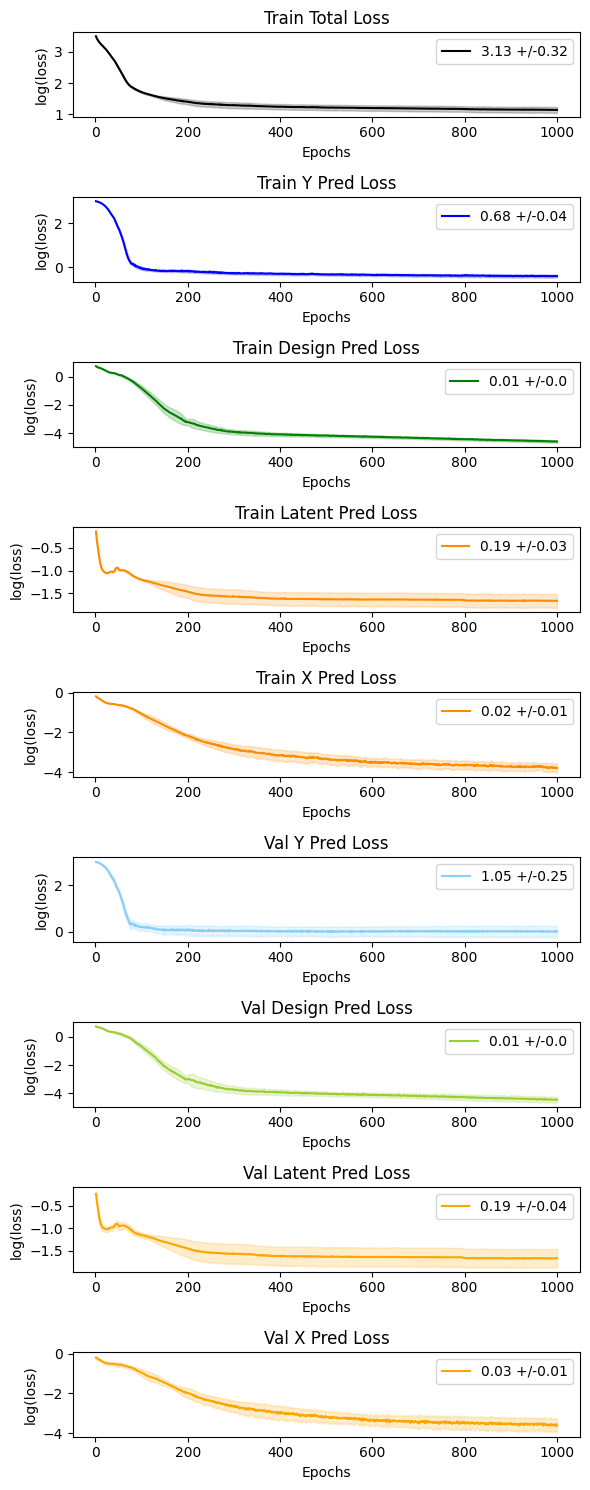

In [7]:
num_latents = len(latent_col_names)
epochs = np.arange(1, num_epochs + 1)
# Plot mean and standard deviation of losses
train_mean_total_pred_loss = np.mean(np.log(np.array(train_total_pred_loss_per_epoch_per_seed)), axis=0)
train_std_total_pred_loss = np.std(np.log(np.array(train_total_pred_loss_per_epoch_per_seed)), axis=0)

train_mean_y_pred_loss = np.mean(np.log(np.array(train_y_pred_loss_per_epoch_per_seed)), axis=0)
train_std_y_pred_loss = np.std(np.log(np.array(train_y_pred_loss_per_epoch_per_seed)), axis=0)

train_mean_design_pred_loss = np.mean(np.log(np.array(train_design_pred_loss_per_epoch_per_seed)), axis=0) 
train_std_design_pred_loss = np.std(np.log(np.array(train_design_pred_loss_per_epoch_per_seed)), axis=0)

if num_latents > 0:
    train_mean_latent_pred_loss = np.mean(np.log(np.array(train_latent_pred_loss_per_epoch_per_seed)), axis=0)
    train_std_latent_pred_loss = np.std(np.log(np.array(train_latent_pred_loss_per_epoch_per_seed)), axis=0)
else:
    train_mean_latent_pred_loss = np.mean(train_latent_pred_loss_per_epoch_per_seed, axis=0)
    train_std_latent_pred_loss = np.std(train_latent_pred_loss_per_epoch_per_seed, axis=0)

train_mean_x_pred_loss = np.mean(np.log(np.array(train_x_pred_loss_per_epoch_per_seed)), axis=0)
train_std_x_pred_loss = np.std(np.log(np.array(train_x_pred_loss_per_epoch_per_seed)), axis=0)

val_mean_y_pred_loss = np.mean(np.log(np.array(val_y_pred_loss_per_epoch_per_seed)), axis=0)
val_std_y_pred_loss = np.std(np.log(np.array(val_y_pred_loss_per_epoch_per_seed)), axis=0)

val_mean_design_pred_loss = np.mean(np.log(np.array(val_design_pred_loss_per_epoch_per_seed)), axis=0)
val_std_design_pred_loss = np.std(np.log(np.array(val_design_pred_loss_per_epoch_per_seed)), axis=0)

if num_latents > 0:
    val_mean_latent_pred_loss = np.mean(np.log(np.array(val_latent_pred_loss_per_epoch_per_seed)), axis=0)
    val_std_latent_pred_loss = np.std(np.log(np.array(val_latent_pred_loss_per_epoch_per_seed)), axis=0)
else:
    val_mean_latent_pred_loss = np.mean(val_latent_pred_loss_per_epoch_per_seed, axis=0)
    val_std_latent_pred_loss = np.std(val_latent_pred_loss_per_epoch_per_seed, axis=0)

val_mean_x_pred_loss = np.mean(np.log(np.array(val_x_pred_loss_per_epoch_per_seed)), axis=0)
val_std_x_pred_loss = np.std(np.log(np.array(val_x_pred_loss_per_epoch_per_seed)), axis=0)

# Plotting
plt.figure(figsize=(6, 15))
plt.subplot(9, 1, 1)
plt.plot(epochs, train_mean_total_pred_loss, 
         label=f'{round(np.mean(np.array(train_total_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_total_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
        color='black')
plt.fill_between(epochs, train_mean_total_pred_loss - train_std_total_pred_loss, 
                 train_mean_total_pred_loss + train_std_total_pred_loss, color='black', alpha=0.2)
plt.title('Train Total Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 2)
plt.plot(epochs, train_mean_y_pred_loss, 
         label=f'{round(np.mean(np.array(train_y_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_y_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='blue')
plt.fill_between(epochs, train_mean_y_pred_loss - train_std_y_pred_loss,
                train_mean_y_pred_loss + train_std_y_pred_loss, color='blue', alpha=0.2)
plt.title('Train Y Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 3)
plt.plot(epochs, train_mean_design_pred_loss, 
         label=f'{round(np.mean(np.array(train_design_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_design_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='green')
plt.fill_between(epochs, train_mean_design_pred_loss - train_std_design_pred_loss,
                 train_mean_design_pred_loss + train_std_design_pred_loss, color='green', alpha=0.2)
plt.title('Train Design Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 4)
plt.plot(epochs, train_mean_latent_pred_loss, 
         label=f'{round(np.mean(np.array(train_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='darkorange')
plt.fill_between(epochs, train_mean_latent_pred_loss - train_std_latent_pred_loss,
                  train_mean_latent_pred_loss + train_std_latent_pred_loss, color='darkorange', alpha=0.2)
plt.title('Train Latent Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 5)
plt.plot(epochs, train_mean_x_pred_loss, 
         label=f'{round(np.mean(np.array(train_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='darkorange')
plt.fill_between(epochs, train_mean_x_pred_loss - train_std_x_pred_loss,
                  train_mean_x_pred_loss + train_std_x_pred_loss, color='darkorange', alpha=0.2)
plt.title('Train X Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 6)
plt.plot(epochs, val_mean_y_pred_loss,
         label=f'{round(np.mean(np.array(val_y_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(val_y_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='lightskyblue')
plt.fill_between(epochs, val_mean_y_pred_loss - val_std_y_pred_loss,
                  val_mean_y_pred_loss + val_std_y_pred_loss, color='lightskyblue', alpha=0.2)
plt.title('Val Y Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 7)
plt.plot(epochs, val_mean_design_pred_loss, 
         label=f'{round(np.mean(np.array(val_design_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(val_design_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='yellowgreen')
plt.fill_between(epochs, val_mean_design_pred_loss - val_std_design_pred_loss, val_mean_design_pred_loss + val_std_design_pred_loss, color='yellowgreen', alpha=0.2)
plt.title('Val Design Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 8)
plt.plot(epochs, val_mean_latent_pred_loss, 
         label=f'{round(np.mean(np.array(val_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-'+
               f'{round(np.std(np.array(val_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='orange')
plt.fill_between(epochs, val_mean_latent_pred_loss - val_std_latent_pred_loss, val_mean_latent_pred_loss + val_std_latent_pred_loss, color='orange', alpha=0.2)
plt.title('Val Latent Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 9)
plt.plot(epochs, val_mean_x_pred_loss, 
         label=f'{round(np.mean(np.array(val_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-'+
               f'{round(np.std(np.array(val_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='orange')
plt.fill_between(epochs, val_mean_x_pred_loss - val_std_x_pred_loss, val_mean_x_pred_loss + val_std_x_pred_loss, color='orange', alpha=0.2)
plt.title('Val X Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.tight_layout()

### Bayesian optimization

In [ ]:
class ExactGPModel(ExactGP, GPyTorchModel):
    _num_outputs = 1
    MIN_INFERRED_NOISE_LEVEL = 1e-5

    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        if kernel == 'RBF':
            self.covar_module = ScaleKernel(RBFKernel())
        elif kernel == 'Matern':
            self.covar_module = ScaleKernel(MaternKernel(nu=2.5))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)
    
def train_model(train_x, train_y, epochs, lr):
    likelihood = GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, 'Matern')

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = ExactMarginalLogLikelihood(likelihood, model)
    for i in range(epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    return model, likelihood

def optimize_acq_fn_and_get_observation(acq_fn, x_test, y_test):
    candidates, _ = optimize_acqf_discrete(
        acq_function=acq_fn,
        choices = x_test, # IMP : Restricts the space from which to select the next candidate 
        q=1, # Number of candidates to select
        max_batch_size=2048,  
        num_restarts=10, # Number of random restarts for optimizer
        raw_samples=512, # Number of random samples for initialization for optimizer
        options={"batch_limit": 5, "maxiter": 200},
        unique=True # Whether to return only unique candidates
    )

    # observe new values. In this case just retreieve 1 value
    x_new = candidates.detach()
    # Find index where it matches in x_test
    match_idx = (x_test == x_new).all(dim = 1)
    # Find where it matches in y_test
    y_new = y_test[match_idx]

    # Remove from the candidate from the test
    x_test = x_test[~match_idx]
    y_test = y_test[~match_idx]

    return x_new, y_new, match_idx, x_test, y_test

In [ ]:
####################################################################################
# Code adopted from PAL2 acquition_function_bo.ipynb. MAKE SURE TO ACK AND CITE !!!
####################################################################################

# First load the model and get the latents and their predictions
x_torch_all = torch.from_numpy(dataset[:, 0:(len(descriptors + latent_col_names))]).to(dtype=torch.float32)
# Using the true values for prediction
y_true = torch.from_numpy(dataset[:, len(descriptors + latent_col_names)]).to(dtype=torch.float32)

# Check for nan in dataset
if np.isnan(x_torch_all).any():
    print('Dataset has NaN values. Please check.')
else:
    print('Dataset has no NaN values.')

maximize = False
verbose = False   
bo_n_trials = 200
bo_n_updates = 10
test_size = 0.9
print(test_size)
bo_n_batches = 100
print(f'bo_n_batches = {bo_n_batches}')
epochs_train_GP = 100
lr_GP = 0.1
save_filename1 = 'bo_results_no_feat_sel_min.csv'
save_filename2 = 'batches_to_reach_optimal_no_feat_sel_min.csv'
save_filename3 = 'selected_latent_hist_no_feat_sel_min.npy'
total_number_of_materials_in_dataset = x_torch_all.shape[0]

# loaded_ae.eval()
# with torch.no_grad():
#     ae_out = loaded_ae(x_torch_all)
# latents = ae_out['z']

latents_stand = x_torch_all
# No need to standardize x_torch_all as it has already been standardized in the beginning
# latents_stand = (latents - latents.mean(dim=0)) / latents.std(dim=0)

# --------------------------------------------------------------

# Sanity check : Identify row indices where the latent values are the same in latents
duplicate_latent_indices = []
for i in range(latents_stand.shape[0]):
    for j in range(i + 1, latents_stand.shape[0]):
        if torch.equal(latents_stand[i], latents_stand[j]):
            duplicate_latent_indices.append((i, j))
if len(duplicate_latent_indices) > 0:
    print(f'Found duplicate latent representations at indices: {duplicate_latent_indices}')
    raise ValueError("Duplicate latent representations found.")

best_obs_val_hist = []
selected_latent_hist = []
selected_obs_hist = []
for trial_num in range(1, bo_n_trials + 1):
    t0 = time.monotonic()

    print(f' ----- Trial {trial_num} ----- ')
    latents_train_stand, latents_test_stand, y_train, y_test = train_test_split(latents_stand, y_true, 
                                                                    test_size=test_size,
                                                                    random_state=trial_num)
    print(f'Train size: {latents_train_stand.shape[0]}, Test size: {latents_test_stand.shape[0]}')

    # check for max in preds
    if maximize : 
        best_obs_val = y_train.max()
        best_obs_val_idx = y_train.argmax()
        optimal_soln = torch.cat([y_train, y_test]).max()
    else:
        best_obs_val = y_train.min()
        best_obs_val_idx = y_train.argmin()
        optimal_soln = torch.cat([y_train, y_test]).min()

    if best_obs_val.eq(optimal_soln):
        if maximize:
            print(f'Max in training set. Removing it. Max value is {optimal_soln}')
        else:
            print(f'Min in training set. Removing it. Min value is {optimal_soln}')
        # removing from train and adding to test
        latents_test_stand = torch.cat([latents_test_stand, latents_train_stand[best_obs_val_idx, :].unsqueeze(0)], dim=0)
        latents_train_stand = torch.cat([latents_train_stand[0:best_obs_val_idx, :], latents_train_stand[best_obs_val_idx + 1:, :]], dim=0)
        y_test = torch.cat([y_test, y_train[best_obs_val_idx].unsqueeze(0)], dim=0)
        y_train = torch.cat([y_train[0:best_obs_val_idx], y_train[best_obs_val_idx + 1:]], dim=0)
        if maximize:
            # Upadting best obs value
            print('Updating best observed value')
            best_obs_val = y_train.max()
        else:
            print('Updating best observed value')
            best_obs_val = y_train.min()

    best_obs_val_batch = []
    best_obs_val_batch.append(best_obs_val)

    selected_latent_batch = []
    selected_obs_batch = []

    likelihood = GaussianLikelihood()
    model = ExactGPModel(latents_train_stand, y_train.squeeze(), likelihood, 'Matern')
    acq_fn = ExpectedImprovement(model=model, best_f=best_obs_val_batch[-1], maximize=maximize)

    for batch_num in range(1, bo_n_batches + 1):
        # Train the model on the initial training data. Then update it with points chosen by the acq. fn from the test set
        if (batch_num - 1)%bo_n_updates == 0:
            if verbose: print(f'Updating the model.')
            model, likelihood = train_model(latents_train_stand, y_train, epochs_train_GP, lr_GP)

        # Here we get the new latent, new observation and the updated latent and observation test sets with that latent and obs removed.
        latent_new, y_new, match_idx, latents_test_stand, y_test = optimize_acq_fn_and_get_observation(acq_fn, latents_test_stand, y_test)
        
        # Add the latent and observation to training set.
        latents_train_stand = torch.cat([latents_train_stand, latent_new], dim=0)
        y_train = torch.cat([y_train, y_new], dim=0)

        # Track the latent and corresponding obs
        selected_latent_batch.append(latent_new)
        selected_obs_batch.append(y_new)

        if maximize:
            best_obs_val_batch.append(y_train.max())
        else:
            best_obs_val_batch.append(y_train.min())

        # Define acquisition function with updated GP model and best observed obs so far.
        acq_fn = ExpectedImprovement(model=model, best_f=best_obs_val_batch[-1], maximize=maximize)

        if verbose:
            print(f'Batch {batch_num}, best obs val {best_obs_val_batch[-1]}')

    t1 = time.monotonic()
    print(f' Time = {round(t1 - t0, 3)}')
    best_obs_val_hist.append(best_obs_val_batch)
    selected_latent_hist.append(selected_latent_batch)
    selected_obs_hist.append(selected_obs_batch)

### Comparing against other bayesian optimization models

#### This is Random Search

In [ ]:
# First load the model and get the latents and their predictions
x_torch_all = torch.from_numpy(dataset[:, 0:(len(descriptors + latent_col_names))]).to(dtype=torch.float32)
# Using the true values for prediction
y_true = torch.from_numpy(dataset[:, len(descriptors + latent_col_names)]).to(dtype=torch.float32)

maximize = True
verbose = False
bo_n_trials = 200
save_filename1 = 'bo_results_random_sampling_max.csv'
save_filename2 = 'batches_to_reach_optimal_random_sampling_max.csv'
save_filename3 = 'selected_latent_hist_random_sampling_max.npy'
total_number_of_materials_in_dataset = 240
bo_n_batches = total_number_of_materials_in_dataset
print(f'bo_n_batches = {bo_n_batches}')

best_obs_val_hist = []
selected_latent_hist = []
selected_obs_hist = []
for trial_num in range(1, bo_n_trials + 1):
    t0 = time.monotonic()

    best_obs_val_batch = []
    selected_latent_batch = []
    selected_obs_batch = []

    x_torch_all_test = copy.deepcopy(x_torch_all)
    y_true_test = copy.deepcopy(y_true)

    for batch_num in range(1, bo_n_batches + 1):
        print(np.arange(0, x_torch_all_test.shape[0]))
        random_idx = random.choice(np.arange(0, x_torch_all_test.shape[0]))
        latent_new = x_torch_all_test[random_idx, :].unsqueeze(0)
        y_new = y_true_test[random_idx].unsqueeze(0)
        match_idx = (x_torch_all_test == latent_new).all(dim = 1)
        # Find where it matches in y_test
        x_torch_all_test = x_torch_all_test[~match_idx]
        y_true_test = y_true_test[~match_idx]

        selected_latent_batch.append(latent_new)
        selected_obs_batch.append(y_new)

        if maximize:
            best_obs_val_batch.append(max(selected_obs_batch))
        else:
            best_obs_val_batch.append(min(selected_obs_batch))

    t1 = time.monotonic()
    print(f' Time = {round(t1 - t0, 3)}')
    best_obs_val_hist.append(best_obs_val_batch)
    selected_latent_hist.append(selected_latent_batch)
    selected_obs_hist.append(selected_obs_batch)



#### This is using SMAC BlackBoxFacade

In [ ]:
# First load the model and get the latents and their predictions
x_torch_all = torch.from_numpy(dataset[:, 0:(len(descriptors + latent_col_names))]).to(dtype=torch.float32)
# Using the true values for prediction
y_true = torch.from_numpy(dataset[:, len(descriptors + latent_col_names)]).to(dtype=torch.float32)

latents_stand = x_torch_all

# Sanity check : Identify row indices where the latent values are the same in latents
duplicate_latent_indices = []
for i in range(latents_stand.shape[0]):
    for j in range(i + 1, latents_stand.shape[0]):
        if torch.equal(latents_stand[i], latents_stand[j]):
            duplicate_latent_indices.append((i, j))
if len(duplicate_latent_indices) > 0:
    print(f'Found duplicate latent representations at indices: {duplicate_latent_indices}')
    raise ValueError("Duplicate latent representations found.")

best_obs_val_hist = []
selected_latent_hist = []
selected_obs_hist = []
for trial_num in range(1, bo_n_trials + 1):
    t0 = time.monotonic()

    print(f' ----- Trial {trial_num} ----- ')
    latents_train_stand, latents_test_stand, y_train, y_test = train_test_split(latents_stand, y_true, 
                                                                    test_size=test_size,
                                                                    random_state=trial_num)
    print(f'Train size: {latents_train_stand.shape[0]}, Test size: {latents_test_stand.shape[0]}')

    # check for max in preds
    if maximize : 
        best_obs_val = y_train.max()
        best_obs_val_idx = y_train.argmax()
        optimal_soln = torch.cat([y_train, y_test]).max()
    else:
        best_obs_val = y_train.min()
        best_obs_val_idx = y_train.argmin()
        optimal_soln = torch.cat([y_train, y_test]).min()

    if best_obs_val.eq(optimal_soln):
        if maximize:
            print(f'Max in training set. Removing it. Max value is {optimal_soln}')
        else:
            print(f'Min in training set. Removing it. Min value is {optimal_soln}')
        # removing from train and adding to test
        latents_test_stand = torch.cat([latents_test_stand, latents_train_stand[best_obs_val_idx, :].unsqueeze(0)], dim=0)
        latents_train_stand = torch.cat([latents_train_stand[0:best_obs_val_idx, :], latents_train_stand[best_obs_val_idx + 1:, :]], dim=0)
        y_test = torch.cat([y_test, y_train[best_obs_val_idx].unsqueeze(0)], dim=0)
        y_train = torch.cat([y_train[0:best_obs_val_idx], y_train[best_obs_val_idx + 1:]], dim=0)
        if maximize:
            # Upadting best obs value
            print('Updating best observed value')
            best_obs_val = y_train.max()
        else:
            print('Updating best observed value')
            best_obs_val = y_train.min()

    best_obs_val_batch = []
    best_obs_val_batch.append(best_obs_val)

    selected_latent_batch = []
    selected_obs_batch = []

    scenario = Scenario(
        configspace=None,
        name='smac',
        output_directory='smac_output',
        deterministic=False,
        objectives=None,
        n_trials=100,
        seed=trial_num,
        n_workers=1
    )

    # Initialize SMAC Gaussian Process model
    train_x = latents_train_stand.numpy()
    train_y = y_train.numpy().reshape(-1, 1)
    test_x = latents_test_stand.numpy()
    test_y = y_test.numpy().reshape(-1, 1)

    
    
    bbf = BlackBoxFacade(scenario)

    # smac_gp = GaussianProcess(scenario)
    # acq_fn = EI(model=smac_gp, best_f=best_obs_val_batch[-1], maximize=maximize)

    for batch_num in range(1, bo_n_batches + 1):
        
        if (batch_num - 1)%bo_n_updates == 0:
            if verbose: print(f'Updating the model.')
            # smac_gp.train(train_x, train_y)


        # Get new latent and observation
        candidates = acq_fn.optimize(test_x)
        latent_new = torch.from_numpy(candidates[0]).to(dtype=torch.float32).unsqueeze(0)
        # Find index where it matches in x_test
        match_idx = (torch.from_numpy(test_x).to(dtype=torch.float32) == latent_new).all(dim = 1)
        # Find where it matches in y_test
        y_new = torch.from_numpy(test_y).to(dtype=torch.float32)[match_idx] 
        # Remove from the candidate from the test
        test_x = test_x[~match_idx.numpy()]
        test_y = test_y[~match_idx.numpy()]

        # Add the latent and observation to training set.
        train_x = np.vstack([train_x, latent_new.numpy()])
        train_y = np.vstack([train_y, y_new.numpy()])
        latents_train_stand = torch.from_numpy(train_x).to(dtype=torch.float32)
        y_train = torch.from_numpy(train_y).to(dtype=torch.float32).squeeze()

        if maximize:
            best_obs_val_batch.append(y_train.max())
        else:
            best_obs_val_batch.append(y_train.min())
        
        # Track the latent and corresponding obs
        selected_latent_batch.append(latent_new)
        selected_obs_batch.append(y_new)

        # Update acquisition function with updated model and best observed value so far
        acq_fn = EI(model=smac_gp, best_f=best_obs_val_batch[-1], maximize=maximize)

        if verbose:
            print(f'Batch {batch_num}, best obs val {best_obs_val_batch[-1]}')

    t1 = time.monotonic()
    print(f' Time = {round(t1 - t0, 3)}')
    best_obs_val_hist.append(best_obs_val_batch)
    selected_latent_hist.append(selected_latent_batch)
    selected_obs_hist.append(selected_obs_batch)


In [ ]:
# Save the dataset x_torch_all and selected_latent_hist to numpy arays
np.save('latents_stand.npy', latents_stand.numpy())
np.save(save_filename3, np.array(selected_latent_hist, dtype=np.float32))

In [ ]:
# overlay the 100 trials in line plot with varying shades of blue
plt.figure(figsize=(8, 6))
for i in range(len(best_obs_val_hist)):
    plt.plot(range(1, len(best_obs_val_hist[i]) + 1), best_obs_val_hist[i], color='blue', alpha=0.1)
    # Mark the initial best observed value
    plt.scatter(1, best_obs_val_hist[i][0], color='red', s=10)

best_obs_val_hist_arr = np.array(best_obs_val_hist)
print(np.mean(best_obs_val_hist_arr, axis=0).shape)
plt.plot(range(1, len(best_obs_val_hist_arr[0]) + 1), np.mean(best_obs_val_hist_arr, axis=0), color='orange', label='Mean of 200 trials', linewidth=2)
plt.legend()

# for i in range(len(selected_obs_hist)):
#     selected_obs_concat = torch.cat(selected_obs_hist[i]).numpy()
#     plt.scatter(range(1, len(selected_obs_concat) + 1), selected_obs_concat, color='blue', s=10, alpha=0.1)
plt.xlabel('Number of evaluated design candidates', fontsize=14)
plt.ylabel('Best Observed Value', fontsize=14)
plt.grid()

### Percent space explored plots

In [ ]:
# Store the hist of best obs val in a numpy array. 
best_obs_val_each_batch_df = pd.DataFrame()
# Store the index of max val in each trial in a list
batches_to_reach_optimal = []
for trial in range(1, bo_n_trials + 1):
    best_obs_val_each_batch_df = pd.concat([best_obs_val_each_batch_df, 
                                            pd.DataFrame(best_obs_val_hist[trial - 1], columns=[f'trial{trial}'])], axis=1)
    if maximize:
        # Need to add the initial training set size. 
        # Another point is that we add the best obs val from the initial training set. So the first entry is not actually selected by the acq. fn.
        # This is fine since anyways argmax index counting starts from 0.
        # print(np.round((1 - test_size)*latents_stand.shape[0], 1))
        batches_to_reach_optimal.append((np.round((1 - test_size)*latents_stand.shape[0], 1)
                                    + best_obs_val_each_batch_df[f'trial{trial}'].argmax())/total_number_of_materials_in_dataset*100)
        
        # # This is only for random sampling
        # batches_to_reach_optimal.append((best_obs_val_each_batch_df[f'trial{trial}'].argmax())/total_number_of_materials_in_dataset*100)
    else:
        batches_to_reach_optimal.append((np.round((1 - test_size)*latents_stand.shape[0], 1)
                                         + best_obs_val_each_batch_df[f'trial{trial}'].argmin())/total_number_of_materials_in_dataset*100)
        
        # # This is only for random sampling
        # batches_to_reach_optimal.append((best_obs_val_each_batch_df[f'trial{trial}'].argmin())/total_number_of_materials_in_dataset*100)

best_obs_val_each_batch_df.to_csv(save_filename1, index=False)
    
# Plot box plot and strip plot of iter_to_reach_max
batches_to_reach_optimal_df = pd.DataFrame(batches_to_reach_optimal, columns=['value'])
batches_to_reach_optimal_df['method'] = 'SimpleBO'
batches_to_reach_optimal_df.to_csv(save_filename2, index=False)

### Decode the latents to find the design conditions

In [ ]:
# Get the last 4 latents before the max/min obs value
choose_idx = 23
if maximize:
    last_latents = chosen_latents[max_idx+choose_idx:max_idx+choose_idx+1]
else:
    last_latents = chosen_latents[min_idx-5:min_idx-4]

# Decode the latents using AE1 decoder
loaded_ae.eval()
inp = torch.from_numpy(last_latents).to(dtype=torch.float32)
with torch.no_grad():
    for i, layer in enumerate(loaded_ae.ae_modules['latents_predictor']):
        if i == 0:
            out1_ae2 = layer(inp)
        else:
            out1_ae2 = layer(out1_ae2)

with torch.no_grad():
    for i, layer in enumerate(loaded_ae.ae_modules['solvent_predictor']):
        if i == 0:
            out2_ae2 = layer(inp)
        else:
            out2_ae2 = layer(out2_ae2)

print("Solvent Categories : 'DMSO', 'THTO', 'DMF', 'NMP', 'ACETONE', 'METHA', 'GBL', 'NITRO'")
print(torch.round(torch.softmax(out2_ae2, dim=1), decimals=3))
print(chosen_obs_vals[max_idx+choose_idx:max_idx+choose_idx+1])

### Loading AE1 to get the deisgn conditions for the perovskite

In [ ]:
fold_num = 5
saved_module_name = 'AE1'
latent_dim = 9
module_params = {'name':'AE1', 
                    'modules':{

                        'encoder':{
                            'input_dim':15,
                            'output_dim':latent_dim, 
                            'hidden_dim':25, 
                            'hidden_layers':1, 
                            'hidden_activation':None, 
                            'output_activation':None, 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },

                        'bandgaps_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':1,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':torch.nn.ReLU(),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        'A_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':5,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':None,
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                        'B_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':6,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':None,
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        },

                        'X_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':3,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':None,
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        }

                    }}

loaded_state_dict = f'runs/nestedae_{saved_module_name}_bandgaps_THEN_perov_solv_BE/nestedae_fold{fold_num}'
loaded_ae2 = AE(module_params)
loaded_ae2.load_state_dict(torch.load(loaded_state_dict))
loaded_ae2.eval()

In [ ]:
inp = out1_ae2
with torch.no_grad():
    for i, layer in enumerate(loaded_ae2.ae_modules['A_predictor']):
        if i == 0:
            out1_ae1 = layer(inp)
        else:
            out1_ae1 = layer(out1_ae1)

with torch.no_grad():
    for i, layer in enumerate(loaded_ae2.ae_modules['B_predictor']):
        if i == 0:
            out2_ae1 = layer(inp)
        else:
            out2_ae1 = layer(out2_ae1)

with torch.no_grad():
    for i, layer in enumerate(loaded_ae2.ae_modules['X_predictor']):
        if i == 0:
            out3_ae1 = layer(inp)
        else:
            out3_ae1 = layer(out3_ae1)

print("A site Categories : 'K', 'Rb', 'Cs', 'MA', 'FA'")
print(torch.round(torch.softmax(out1_ae1, dim=1), decimals=3))
print("B site Categories : 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb'")
print(torch.round(torch.softmax(out2_ae1, dim=1), decimals=3))
print("X site Categories : 'Cl', 'Br', 'I'")
print(torch.round(torch.softmax(out3_ae1, dim=1), decimals=3))